In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
import lime
import warnings as wr
wr.filterwarnings('ignore')

In [2]:
df = pd.read_csv('loan_clean.csv')
df = df.sample(frac = 0.001)
df.shape

(1091, 49)

In [3]:
df['purpose'].value_counts()

purpose
debt_consolidation    649
credit_card           233
home_improvement       68
other                  60
major_purchase         23
medical                15
small_business         12
car                    11
vacation                7
moving                  7
house                   5
wedding                 1
Name: count, dtype: int64

In [5]:
list = ['avg_cur_bal', 'last_fico_range_high', 'last_fico_range_low',
       'loan_amnt', 'pub_rec_bankruptcies', 'term', 'year', 'num_actv_rev_tl',
       'num_bc_tl', 'mths_since_recent_bc', 'application_type_Individual',
       'grade_C', 'initial_list_status_f', 'purpose_credit_card', 'purpose_moving']

In [6]:
y = df['default']

In [7]:
type(df[df['default']==1])

pandas.core.frame.DataFrame

In [13]:
dummy = df.columns.tolist()
dummy.remove('default')

In [15]:
X = pd.get_dummies(df[dummy],dtype='int')
X.shape

(1091, 72)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X[list], y, test_size=0.3,random_state=555, stratify=y)

In [19]:

model = Sequential()
model.add(Dense(units=77,activation='relu'))
model.add(Dense(units=39,activation='relu'))
model.add(Dense(units=19,activation='relu'))
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=4,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.7193 - loss: 0.6780 - val_accuracy: 0.8018 - val_loss: 0.6635
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8110 - loss: 0.6623 - val_accuracy: 0.8201 - val_loss: 0.6494
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8322 - loss: 0.6481 - val_accuracy: 0.8262 - val_loss: 0.6344
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8222 - loss: 0.6321 - val_accuracy: 0.8262 - val_loss: 0.6172
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8252 - loss: 0.6140 - val_accuracy: 0.8262 - val_loss: 0.5978
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8291 - loss: 0.5937 - val_accuracy: 0.8262 - val_loss: 0.5765
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8304 - loss: 0.5710 - val_accuracy: 0.8262 - val_loss: 0.5537
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8232 - loss: 0.5486 - val_accuracy: 0.8262 - val_loss: 0.5301

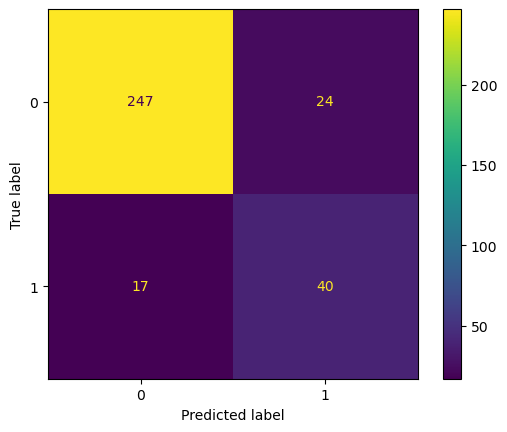

In [21]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=50,
          batch_size=512,
          validation_data=(X_test, y_test), verbose=1)
predictions = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [41]:
model.predict(X_test)[53]*100

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


array([0.05177892], dtype=float32)

In [68]:
shap.initjs()
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test.iloc[0, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], X_test.iloc[0, :])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


Using 763 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
49548/49548 ━━━━━━━━━━━━━━━━━━━━ 25s 500us/step


In [34]:
# compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

PermutationExplainer explainer: 764it [01:05, 10.14it/s]                         


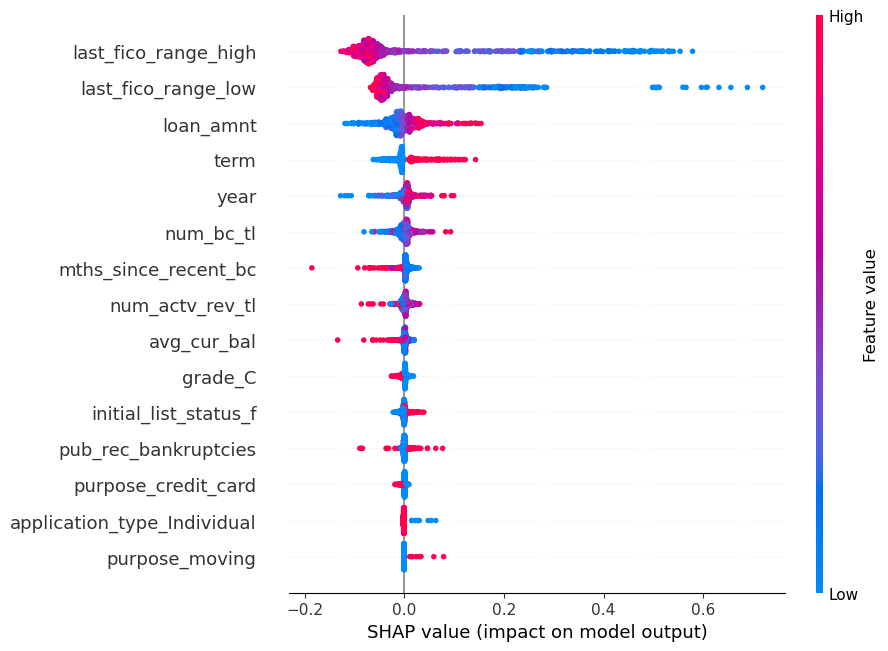

In [35]:
shap.plots.beeswarm(shap_values,max_display=20)

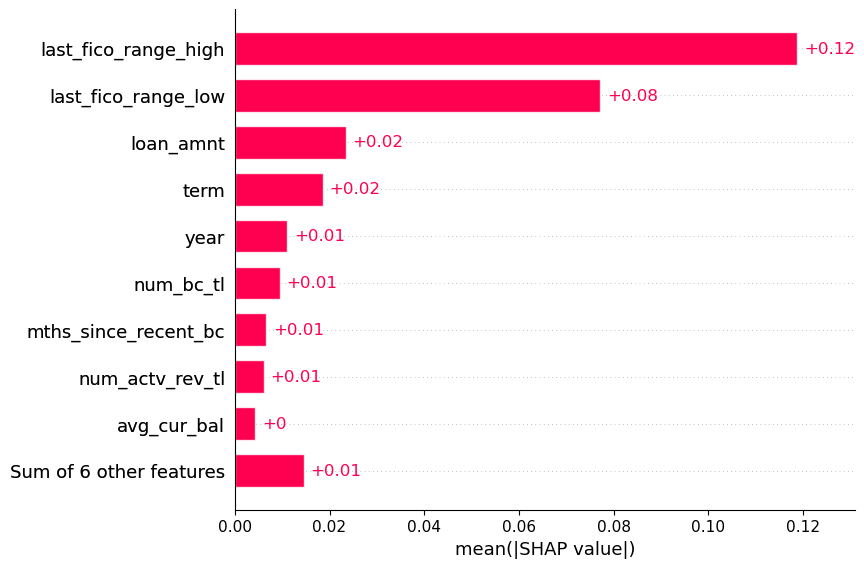

In [36]:
shap.plots.bar(shap_values.abs.mean(0))

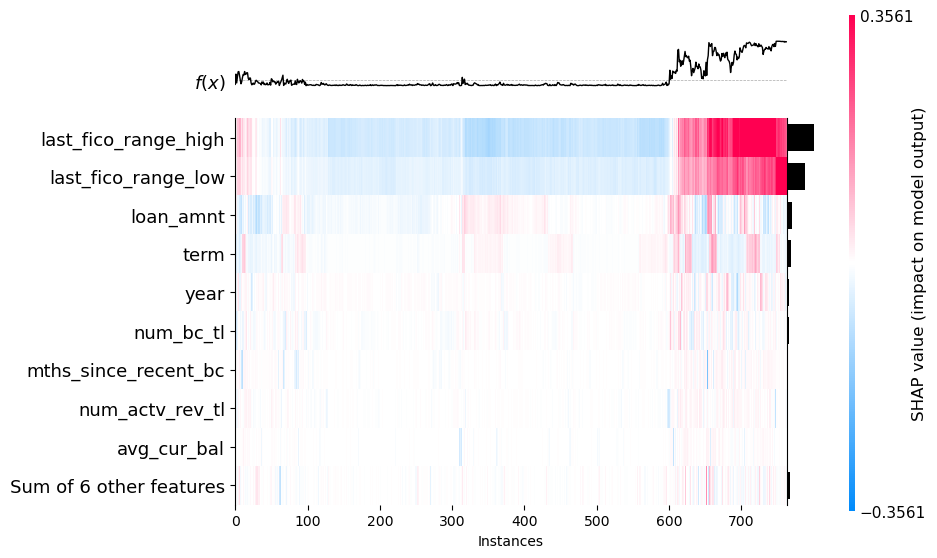

<Axes: xlabel='Instances'>

In [37]:
shap.plots.heatmap(shap_values)

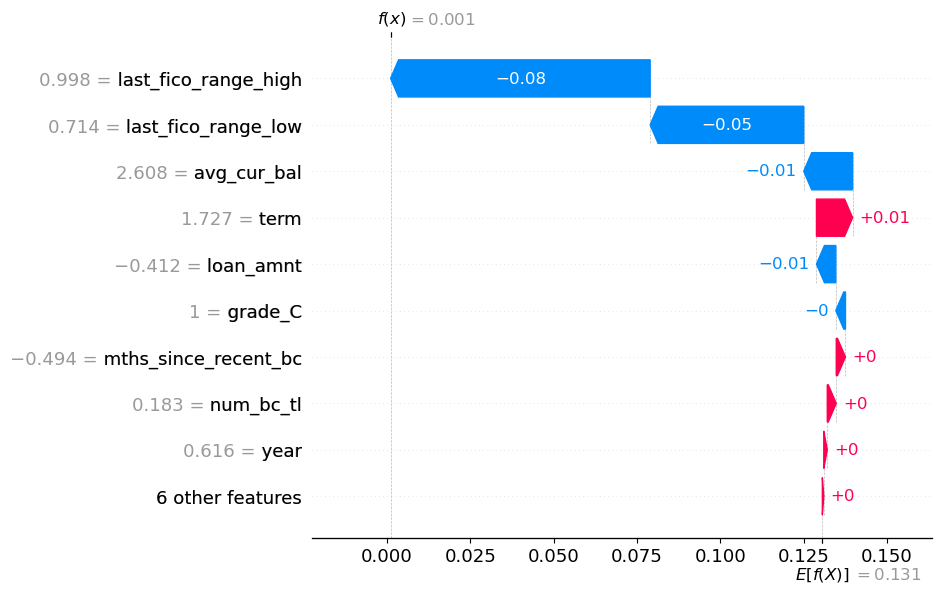

In [38]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.dependence_plot('last_fico_range_high', shap_values[0], X_train)

In [25]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['Default', 'Non-Default']

# Get the feature names
feature_names = X_train.columns.to_list()

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification', discretize_continuous=True)
# obtaining the explanation
explanation = lime_explainer.explain_instance(data_row=X_test.iloc[53], predict_fn=model.predict, top_labels=6, num_features=13)

# printing out the explanation
explanation.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


In [40]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['Default', 'Non-Default']

# Get the feature names
feature_names = X_train.columns.to_list()

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')
# obtaining the explanation
explanation = lime_explainer.explain_instance(data_row=X_test.iloc[0], predict_fn=model.predict, top_labels=6, num_features=13)

# printing out the explanation
explanation.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
